In [ ]:
# -------------------------------------------------------------------------------------------------------------
# Imports
# -------------------------------------------------------------------------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim
from training_evaluation.trainer_evaluator import TRAINER_EVALUATOR

In [2]:
# -------------------------------------------------------------------------------------------------------------
# System path for imports
# -------------------------------------------------------------------------------------------------------------
PROJECT_ROOT='./'
import sys
sys.path.append(PROJECT_ROOT)

## Experiment 1: CNN + Transformer Hybrid Architecture

Contains the hybrid architecture with element wise product of features

### Image patching

In [16]:
# -------------------------------------------------------------------------------------------------------------
# Factorization
# Calculate the factors and return the optimal number of rows and columns for patches
# -------------------------------------------------------------------------------------------------------------

def factorization(number):
    factors = []

    for i in range(1, number+1):
        if number%i == 0:
            factors.append(i)
    
    middle_value = int(len(factors) / 2)
    factors = factors[middle_value:]
    middle = int(len(factors) / 2)
    partitions = int(number / factors[middle])
    patch_size = factors[middle]
    return patch_size, partitions




# -------------------------------------------------------------------------------------------------------------
# Patching
# -------------------------------------------------------------------------------------------------------------
def convert_to_patches(image):
    # Factorize and choose maximum factor
    C, H, W = image.shape
    if H == W:
        rows = columns = int(np.sqrt(H))
    else:
        # call factorization method
        row_size, rows = factorization(H)
        column_size, columns = factorization(W)

    img_patches = []
    patches = []
    for i in range(0, H, row_size):
        for j in range(0, W, column_size):
            patches.append(image[:, i: i+row_size, j: j+column_size])
            img_patches.append(ToPILImage()(image[:, i: i+row_size, j: j+column_size]))

    patch_tensors = torch.stack(patches, dim=0)

    return patches, patch_tensors, columns

# -------------------------------------------------------------------------------------------------------------
# Stitching
# -------------------------------------------------------------------------------------------------------------
def stitch_image(patches, columns):
    stitched_image = []
    for i in range(0, len(patches[:]), columns):
        row = torch.cat(patches[:][i:i+columns], dim=2)
        stitched_image.append(row)

    final_image = torch.cat(stitched_image, dim=1)
    stitched_pil = ToPILImage()(final_image)
    stitched_pil.show()

    return stitched_pil

# Preliminary transforms
transform = transforms.Compose([transforms.ToTensor()])
raw_image = Image.open("./Go_Pro_1.png").convert('RGB')
image = transform(raw_image)
C, H, W = image.shape
print(f"Channels, height and width: {C, H, W}")

img_patches, tensors,columns = convert_to_patches(image)
stitched_pil = stitch_image(img_patches, columns)
print(np.array(stitched_pil).shape)

Channels, height and width: (3, 720, 1280)
(720, 1280, 3)


### CNN-ViT Hybrid Model

#### Training for CNN-ViT hybrid with patching and custom transformer

In [ ]:
# -------------------------------------------------------------------------------------------------------------
# Training for CNN-ViT hybrid with patching and custom transformer
# -------------------------------------------------------------------------------------------------------------
def train_patching(model, dataloader, optimizer, epochs=5,log_file='training_log.txt', best_model_dir='best_models/'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.MSELoss()

    os.makedirs(best_model_dir, exist_ok=True)
    best_loss = float('inf')

    # Define structures for capturing loss and epochs
    history = {
        "train_loss": [],
        "epochs": []
    }

    # Open log file
    with open(log_file, 'w') as log:
        for epoch in range(epochs):
            model.train()
            total_loss = 0.0

            for blurry, sharp in dataloader:
                blurry = blurry.to(device)
                sharp = sharp.to(device)

                input_blurry_patches, image_blurry_tensors, columns = convert_to_patches(blurry)
                gt_patches, gt_patch_tensors, columns = convert_to_patches(sharp)

                
                optimizer.zero_grad()
                output = model(image_blurry_tensors)
                loss = criterion(output, gt_patch_tensors)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            history['train_loss'].append(avg_loss)
            history['epochs'].append(epoch)

            # Save best model
            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save(model.state_dict(), os.path.join(best_model_dir, 'best_model.pth'))

            # Logging
            log_line = f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}\n"
            print(log_line.strip())
            log.write(log_line)
            log.flush()

        # Visualization
        plt.plot(np.array(history['epochs']), np.array(history['train_loss']))
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Epoch for Pretrained CNN-ViT Hybrid with no patching")
        plt.show()

# -------------------------------------------------------------------------------------------------------------
# Evaluation for CNN-ViT hybrid with patching and custom transformer
# -------------------------------------------------------------------------------------------------------------
def evaluate_model_on_patches(model, val_loader, criterion, patch_size, stride, device):
    model.eval()
    total_loss = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    image_count = 0

    with torch.no_grad():
        for blur, sharp in val_loader:
            blur = blur.to(device)
            sharp = sharp.to(device)

            input_blurry_patches, image_blurry_tensors, columns = convert_to_patches(blur)
            gt_patches, gt_patch_tensors, columns = convert_to_patches(sharp)

            outputs = model(image_blurry_tensors)
            loss = criterion(outputs, gt_patch_tensors)
            total_loss += loss.item()

            # Move to CPU for PSNR/SSIM
            outputs = list(torch.unbind(outputs, dim=0))
            stitched_output = stitch_image(outputs, columns)
            outputs_cpu = np.array(stitched_output)
            targets_cpu = np.array(sharp)

            
            out_img = np.clip(outputs_cpu, 0, 1)
            tgt_img = np.clip(targets_cpu, 0, 1)

            psnr_total += compute_psnr(tgt_img, out_img, data_range=1.0)
            ssim_total += compute_ssim(tgt_img, out_img, data_range=1.0, channel_axis=2)
            image_count += 1

    avg_loss = total_loss / len(val_loader.dataset)
    avg_psnr = psnr_total / image_count
    avg_ssim = ssim_total / image_count

    return avg_loss, avg_psnr, avg_ssim

/opt/anaconda3/envs/HLCV/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


CNN Features: torch.Size([512, 784]) = 512 channels, 28.0 height, width
Attention shape: torch.Size([1, 197, 197])
Attention Map reshaped: torch.Size([1, 1, 197, 197])
Attention Map after interpolation: torch.Size([1, 1, 512, 784])
Attention Map resized: torch.Size([1, 512, 512, 784])


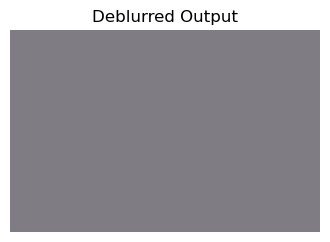

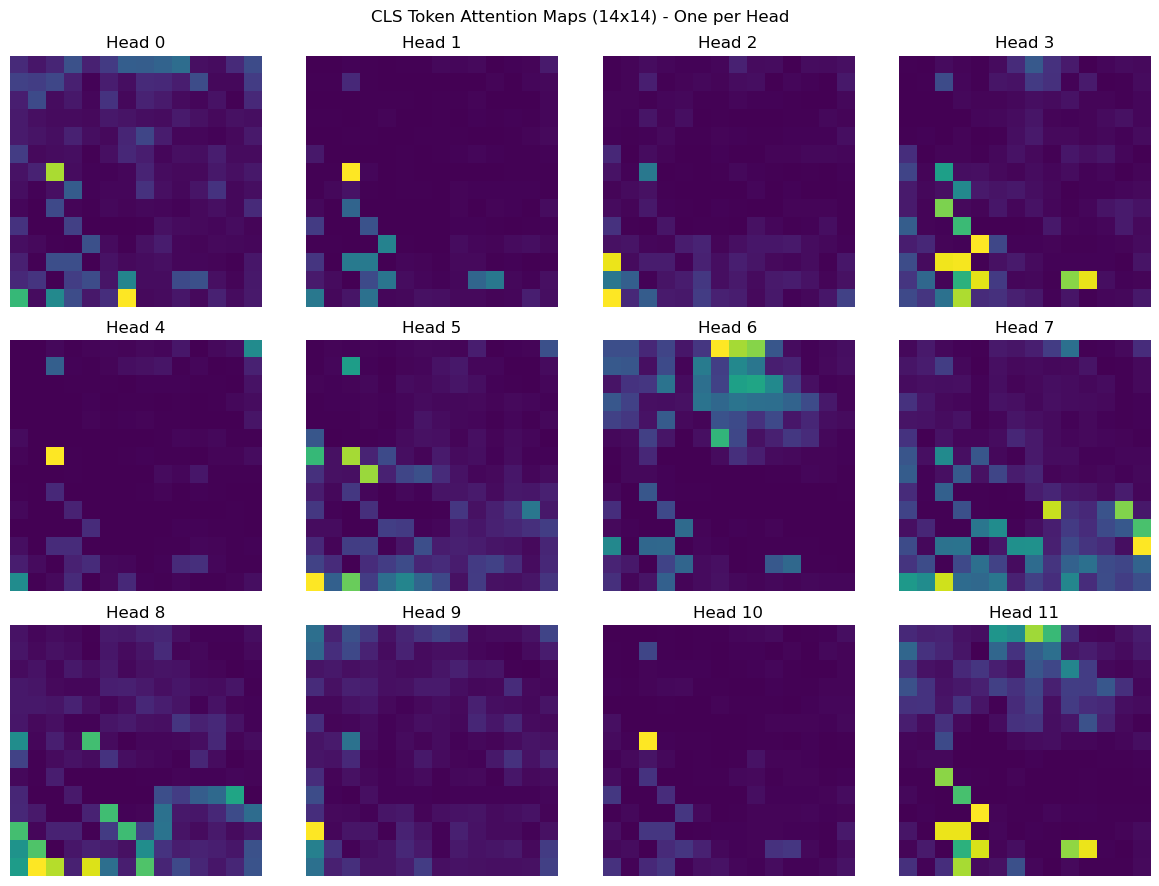

torch.Size([1, 3, 512, 784])


In [11]:
# -------------------------------------------------------------------------------------------------------------
# Driver Code
# -------------------------------------------------------------------------------------------------------------
from architecture.cnn_vit_hybrid_architecture import CNN_VIT_HYBRID_ARCHITECTURE

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
raw_image = Image.open("./Blur.png").convert('RGB')
image = transform(raw_image)


# -------------------------------------------------------------------------------------------------------------
# Run experiments
# -------------------------------------------------------------------------------------------------------------
model = CNN_VIT_HYBRID_ARCHITECTURE()
output = model(image)
print(output.shape)

#### Training for CNN-ViT hybrid without patching and pretrained weights

In [ ]:
print("Training started...")
trainer_evaluator = TRAINER_EVALUATOR()
trainer_evaluator.train_pretrained_cnn_vit_no_patch(model, train_loader, optimizer, criterion, 100)

print("Loading best model for evaluation...")
try:
    model.load_state_dict(torch.load('/home/hlcv_team041/Project/best_models/cnn_vit_dot_product_no_patch/best_model.pth'))
except FileNotFoundError:
    print("Best model file not found. Skipping evaluation and visualization.")
    exit()

print("Evaluating on test set...")
trainer_evaluator.eval_pretrained_cnn_vit_no_patch(model, val_loader, criterion)